# imports

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [4]:
!rm -r "/content/oral-cancer-dataset.zip" #if already exists delete
!rm -r "/content/dataset" #if already exists delete

rm: cannot remove '/content/oral-cancer-dataset.zip': No such file or directory


In [5]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json     #giving permission
!kaggle datasets download -d zaidpy/oral-cancer-dataset
!unzip "/content/oral-cancer-dataset.zip" -d "/content/dataset/"  # UNZIP

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/zaidpy/oral-cancer-dataset
License(s): apache-2.0
 97% 305M/315M [00:01<00:00, 250MB/s]
100% 315M/315M [00:01<00:00, 229MB/s]
Archive:  /content/oral-cancer-dataset.zip
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/001.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/002.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/003.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/004.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/005.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/006.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/007.jpeg  
  inflating: /content/dataset/Ora

# DATA MANAGEMENT

## Changing data

there are two folders so we are just shifting from old to the new dir

In [6]:
#Renaming Folder
import os
os.rename("/content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER","/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer")
os.rename("/content/dataset/Oral Cancer/Oral Cancer Dataset/NON CANCER","/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer")

import shutil
folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[str(file) for file in files]
for i in lis:
  os.rename("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+i,"/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+str(0)+i)


folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[file for file in files]
for i in lis:
  os.rename("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+i,"/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+str(0)+i)


In [7]:
#moving files
folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[str(file) for file in files]
for i in lis:
    shutil.move("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+i,"/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer")

folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[file for file in files]
for i in lis:
    shutil.move("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+i,"/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer")

In [8]:
#delete corrupt fies
import os
import imghdr
count=0
path = "/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer"
dir_ = os.listdir(path)
for image in dir_:
    file = os.path.join(path,image)
    if not imghdr.what(file):
        count=count+1
        os.remove(file)

path = "/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer"
dir_ = os.listdir(path)
for image in dir_:
    file = os.path.join(path,image)
    if not imghdr.what(file):
        count=count+1
        os.remove(file)
print("Corrupt files are {}".format(count))

Corrupt files are 24


In [11]:
!rm -r "/content/dataset/Oral cancer Dataset 2.0" #delete after empty
# !rm -r "/content/dataset"

## process DATA

In [11]:
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/content/dataset/Oral Cancer/Oral Cancer Dataset"
images, labels = load_data(folder_path)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Stacking

In [16]:
model1 = tf.keras.models.load_model('/content/models/efficient_net_B2.keras')
model2 = tf.keras.models.load_model('/content/models/best_model_resnet.keras')
model3 = tf.keras.models.load_model('/content/models/vgg19.keras')

In [17]:
X_train,X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=100, shuffle=True)
preds_model1 = model1.predict(X_train)
preds_model2 = model2.predict(X_train)
preds_model3 = model3.predict(X_train)
stacked_preds = np.column_stack((preds_model1, preds_model2, preds_model3))

X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(stacked_preds, y_train, test_size=0.2, random_state=42)

meta_learner = RandomForestClassifier()
meta_learner.fit(X_train_meta, y_train_meta)

test_preds_model1 = model1.predict(X_test)
test_preds_model2 = model2.predict(X_test)
test_preds_model3 = model3.predict(X_test)

stacked_test_preds = np.column_stack((test_preds_model1, test_preds_model2, test_preds_model3))

final_predictions = meta_learner.predict(stacked_test_preds)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1436s 34s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 242s 6s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1046s 25s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 384s 35s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 263s 24s/step


In [51]:
print(stacked_test_preds)
print(final_predictions)
print(y_test)
print(accuracy_score(y_test,final_predictions))

[[7.4724340e-01 2.3536809e-02 1.6319571e-02]
 [9.1716212e-01 9.9975282e-01 9.9999964e-01]
 [9.9940622e-01 9.9944776e-01 9.9963832e-01]
 ...
 [1.3783063e-04 7.4923351e-05 2.3143228e-05]
 [9.9998212e-01 9.9997890e-01 1.0000000e+00]
 [3.7167615e-07 5.4773453e-05 2.4510862e-06]]
[0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0
 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1
 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0
 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0
 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0
 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 0]
[0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 

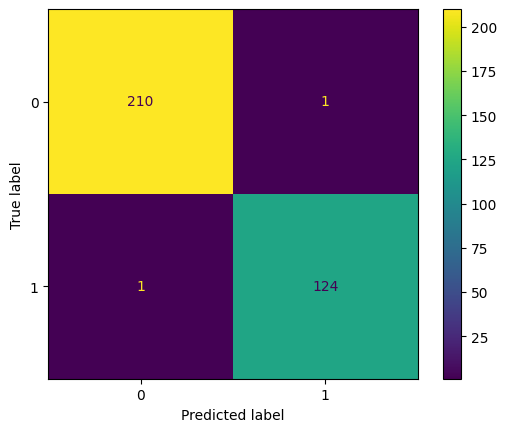

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
precision = precision_score(y_test,final_predictions)
recall = recall_score(y_test,final_predictions)
f1 = f1_score(y_test,final_predictions)
report = classification_report(y_test,final_predictions)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Classification Report:\n", report)

Precision: 0.992
Recall: 0.992
F1-Score: 0.992
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       0.99      0.99      0.99       125

    accuracy                           0.99       336
   macro avg       0.99      0.99      0.99       336
weighted avg       0.99      0.99      0.99       336



In [18]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, final_predictions))
print("Classification Report:\n", classification_report(y_test, final_predictions))


Accuracy: 0.9940476190476191
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       0.99      0.99      0.99       125

    accuracy                           0.99       336
   macro avg       0.99      0.99      0.99       336
weighted avg       0.99      0.99      0.99       336



# save model


In [20]:
import pickle

# Save the meta-learner to a file
with open('/content/meta_learner_model.pkl', 'wb') as file:
    pickle.dump(meta_learner, file)

load

In [21]:
import pickle

# Load the meta-learner from the file
with open('meta_learner_model.pkl', 'rb') as file:
    loaded_meta_learner = pickle.load(file)

##test

In [54]:
model1 = tf.keras.models.load_model('/content/models/efficient_net_B2.keras')
model2 = tf.keras.models.load_model('/content/models/best_model_resnet.keras')
model3 = tf.keras.models.load_model('/content/models/vgg19.keras')
import cv2

In [68]:
# img=cv2.imread("/content/non_cancer.png")
# img=cv2.imread("/content/image_caner.png")
# img=cv2.imread("/content/non_cancer.jpg")
# img=cv2.imread("/content/non_cancer2.jpg")
img=cv2.imread("/content/non_cance3.jpg")
img=cv2.resize(img,(224,224))
img= tf.expand_dims(img,axis=0)

model1_pred= model1.predict(img)
print(model1_pred)
model2_pred= model2.predict(img)
print(model2_pred)
model3_pred= model3.predict(img)
print(model3_pred)

stacked_predss = np.column_stack((model1_pred, model2_pred, model3_pred))
print(stacked_predss)

meta_learner.predict(stacked_predss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
[[0.9999633]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
[[0.9985689]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
[[0.9999999]]
[[0.9999633 0.9985689 0.9999999]]


array([1])